In [1]:
%matplotlib inline

import glob
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import DBSCAN

from joblib import Parallel, delayed

In this notebook, we put together a pipeline to cluster papers based on the functionality of previous notebooks. This pipeline is parametrised. The objective is to apply model selection to select the best value of the hyperparameters. Model selection is based on grid search. However, given the high number of hyperparameter the model selection process is iterative and from coarse to fine: we start with a coarse grid and focus on search on promising areas of the hyperparameter space. 

## Defining the pipeline

In [2]:
def get_papers():
    papers = sorted(glob.glob('data/*.txt'))
    df = pd.DataFrame(columns=['paper', 'len'], index=range(len(papers)))

    i = 0
    for paper in papers:
        with open(paper, 'r') as f:
            text = f.readlines()
        df.iloc[i, :] = [paper, len(text[0])]
        i = i + 1
    df = df[~(df['len'] < 5000) & ~(df['len'] > 80000)]
    
    return df

In [3]:
def build_bag_of_words(df, max_df = 0.7, min_df = 0.3):
    count_vect = TfidfVectorizer(input='filename', max_df = max_df, min_df = min_df)
    X_freq = count_vect.fit_transform(df.paper.values.tolist())
    
    return X_freq

In [4]:
def apply_lsa(X_freq, n_components = 15):
    X_lsa = TruncatedSVD(n_components = n_components, random_state=0).fit_transform(X_freq)
    
    return X_lsa

In [5]:
def apply_dimensionality_reduction(X_lsa):
    X_embedded = TSNE(n_components=2).fit_transform(X_lsa)
    
    return X_embedded

In [6]:
def kmeans_clustering(X_embedded, k = 20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_embedded)
    shil = silhouette_score(X_embedded, kmeans.labels_)
    
    return kmeans, shil

In [7]:
def dba_clustering(X_embedded, eps = 1.5, min_samples = 5):
    dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(X_embedded)
    if len(np.unique(dbscan.labels_).tolist()) > 1:
        shil = silhouette_score(X_embedded, dbscan.labels_)
    else:
        shil = -1
        
    return dbscan, shil

In [8]:
def plot_kmeans(X_embedded, kmeans):
    fig, ax = plt.subplots()
    ax.scatter(X_embedded[:,0], X_embedded[:,1], c = kmeans.labels_, cmap="gist_rainbow")
    i = 0
    for c in kmeans.cluster_centers_:
        plt.annotate(
            str(i),
            xy=(c[0], c[1]), xytext=(0,0),
            textcoords='offset points', ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
        i = i + 1
    fig.set_figwidth(16)
    fig.set_figheight(16)

In [9]:
def plot_dbscan(X_embedded, dbscan):
    fig, ax = plt.subplots()
    ax.scatter(X_embedded[:,0], X_embedded[:,1], c = dbscan.labels_, cmap="gist_rainbow")

    labels = np.unique(dbscan.labels_).tolist()

    for i in range(len(labels)):
        if labels[i] != -1:
            center = [np.mean(X_embedded[dbscan.labels_ == labels[i], 0]), 
                      np.mean(X_embedded[dbscan.labels_ == labels[i], 1])]
            plt.annotate(
                str(labels[i]),
                xy=(center[0], center[1]), xytext=(0,0),
                textcoords='offset points', ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))
    fig.set_figwidth(16)
    fig.set_figheight(16)

Shilouette score kmeans: 0.5042177
Shilouette score dbscan: 0.13675264


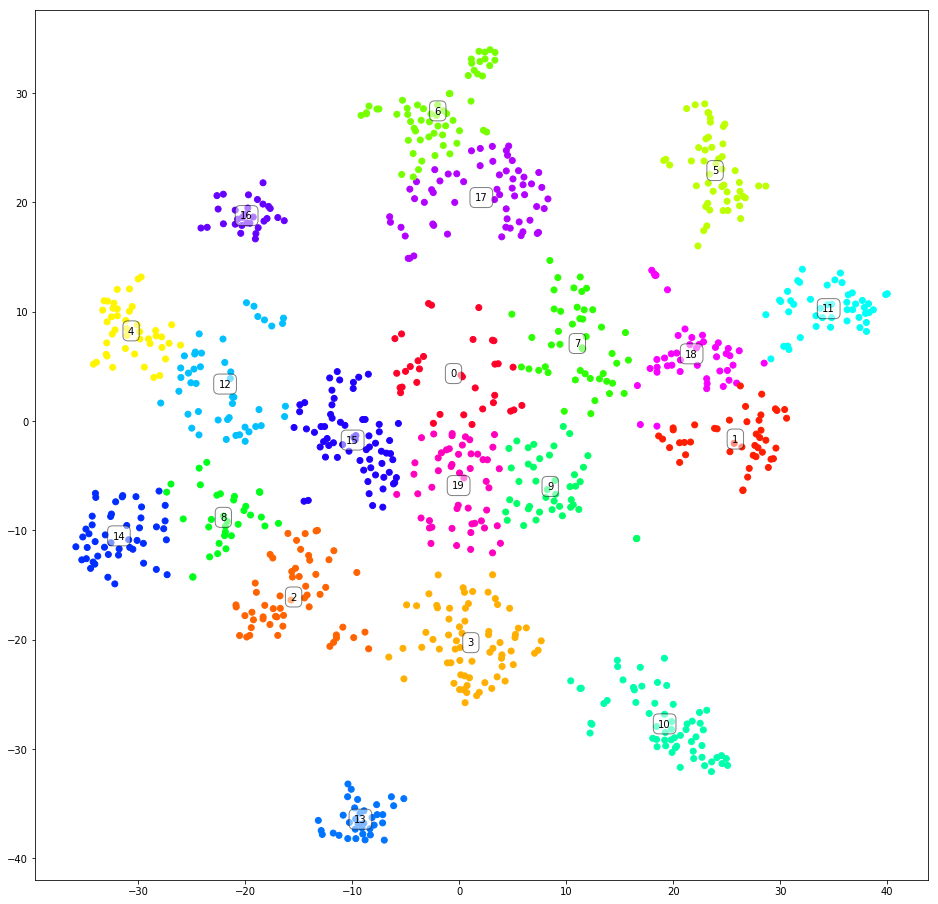

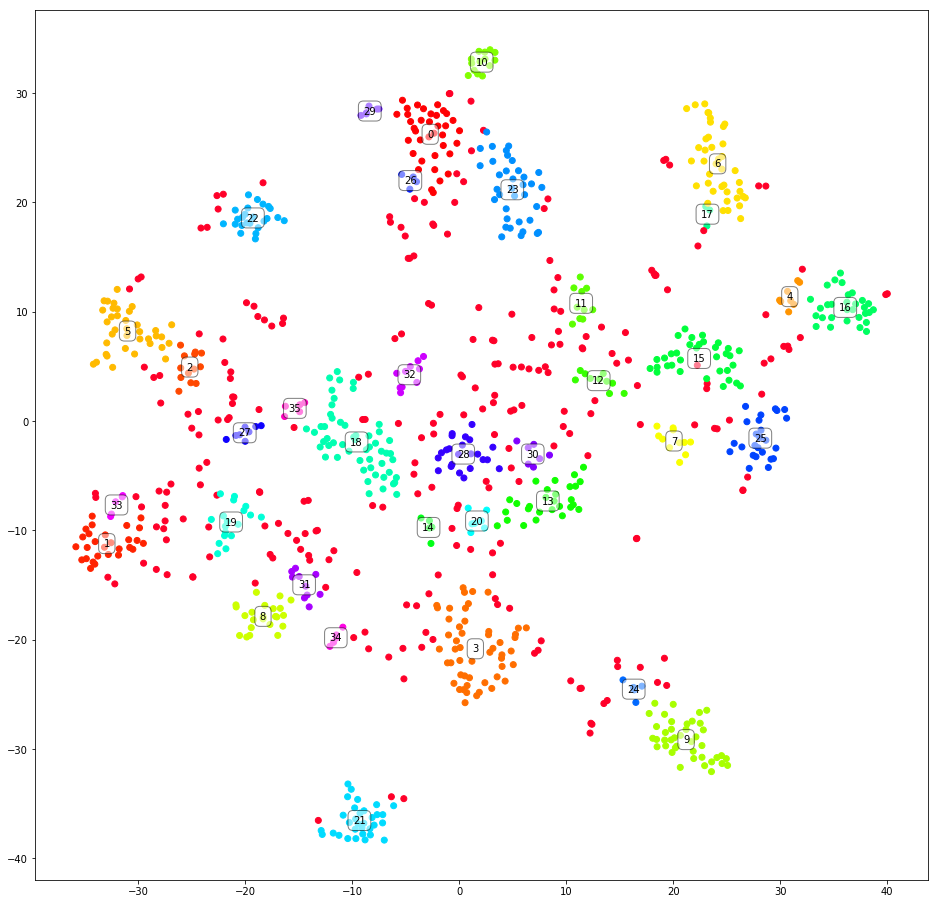

In [10]:
# Testing the pipeline
df = get_papers()
X_freq = build_bag_of_words(df, max_df = 0.7, min_df = 0.3)
X_lsa = apply_lsa(X_freq, n_components = 15)
X_embedded = apply_dimensionality_reduction(X_lsa)
kmeans, shil_kmeans = kmeans_clustering(X_embedded, k = 20)
dbscan, shil_dbscan = dba_clustering(X_embedded, eps = 1.5, min_samples=5)
print('Shilouette score kmeans: ' + str(shil_kmeans))
print('Shilouette score dbscan: ' + str(shil_dbscan))
plot_kmeans(X_embedded, kmeans)
plot_dbscan(X_embedded, dbscan)

## K-means model selection

Applying model selection to k-means. Starting with a coarse grid given the number of hyparameters. I will refine by exploring the hyperpameters space at increasingly lower resolution levels

In [11]:
def pipeline_kmeans(input_data):
            df = input_data[0]
            max_df = input_data[1]
            min_df = input_data[2]
            n_components = input_data[3]
            k = input_data[4]

            X_freq = build_bag_of_words(df, max_df = max_df, min_df = min_df)
            X_lsa = apply_lsa(X_freq, n_components = n_components)
            X_embedded = apply_dimensionality_reduction(X_lsa)
            kmeans, shil_kmeans = kmeans_clustering(X_embedded, k = k)
            return [shil_kmeans, kmeans, max_df, min_df, n_components, k, X_embedded]

In [12]:
def grid_search_kmeans(max_df_values, 
                       min_df_values, 
                       n_components_values, 
                       k_values,
                       output_file,
                       n_jobs = 8):
    if not os.path.exists(output_file):
        # Pipeline initialisation
        df = get_papers()
        
        # Building the grid search space
        grid_search = [(df, max_df, min_df, n_components, k) 
                         for max_df in max_df_values
                         for min_df in min_df_values
                         for n_components in n_components_values
                         for k in k_values]

        # Running the pipeline for all the elements in the grid search space
        results = Parallel(n_jobs=n_jobs)(delayed(pipeline_kmeans)(gs) for gs in tqdm(grid_search))

        # Processing the results data
        results_df = pd.DataFrame([], columns = ['shil', 'max_df', 'min_df', 'n_components', 'k'])
        for r in results:
            results_df.loc[len(results_df) + 1, :] = [r[0], r[2], r[3], r[4], r[5]]
        for c in results_df.columns:
            results_df[c] = results_df[c].astype(float)
        results_df.to_csv(output_file)
    else:
        results_df = pd.read_csv(output_file, index_col=[0])

    # Plotting the results
    fig, ax = plt.subplots(2,2)
    r = 0
    c = 0
    for col in results_df.columns[1:]:
        averages = results_df[[col, 'shil']].groupby(col).mean().sort_index()
        stds = results_df[[col, 'shil']].groupby(col).std().sort_index()

        ax[r, c].plot(averages.index.values, averages.values)
        ax[r, c].fill_between(averages.index.values, 
                        averages.values.flatten() - stds.values.flatten(),
                        averages.values.flatten() + stds.values.flatten(), 
                        alpha = 0.5)
        ax[r, c].grid(True)
        ax[r, c].set_xlabel(col)
        ax[r, c].set_ylabel('shil')

        c = c + 1
        if c > 1:
            c = 0
            r = r + 1
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.tight_layout()

In [13]:
max_df_values = np.arange(0.7, 1, 0.1)
min_df_values = np.arange(0, 0.3, 0.1)
n_components_values = range(5, 50, 10)
k_values = range(2, 50, 5)

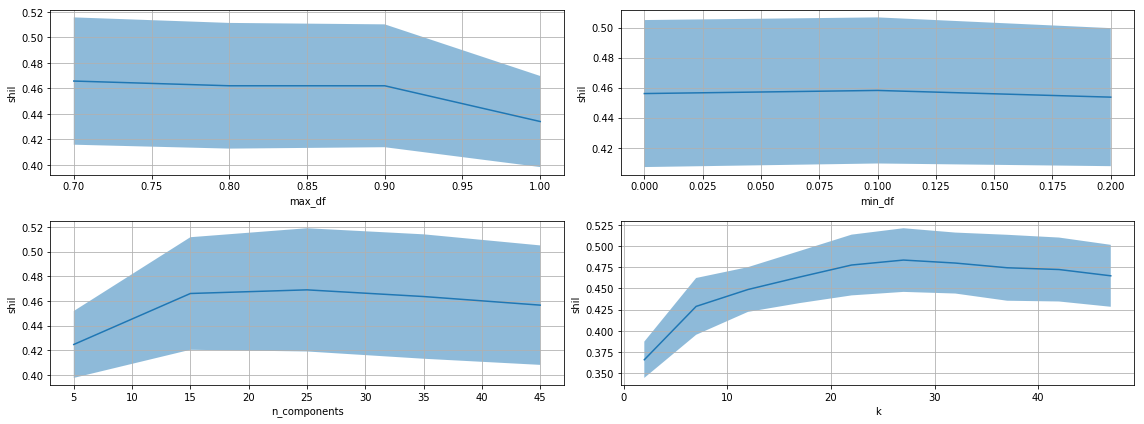

In [14]:
grid_search_kmeans(max_df_values, 
                       min_df_values, 
                       n_components_values, 
                       k_values,
                       'checkpoints/coarse.csv')

We can see clear maxima in these plots, except in the case of the max_df parameter. Applying a higher resolution gridsearch using narrower ranges of hyperparameter values and smaller steps.

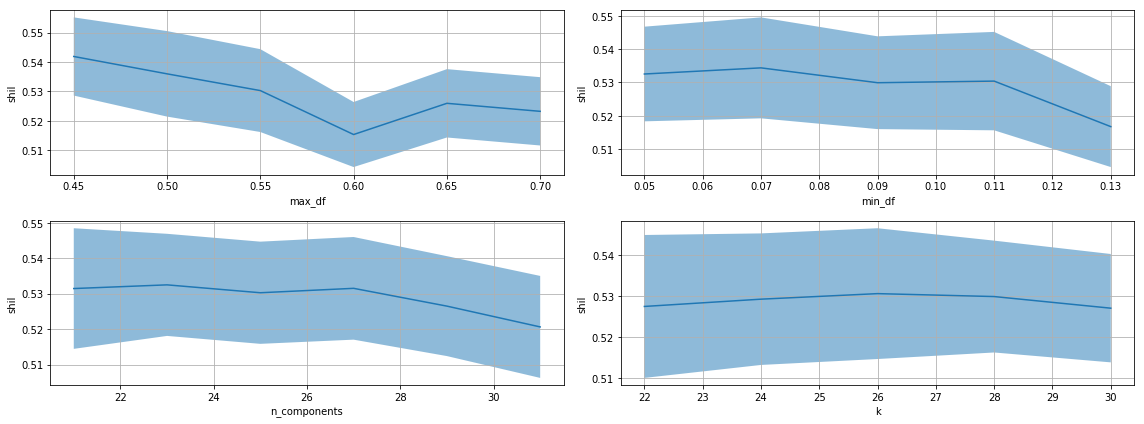

In [15]:
max_df_values = np.arange(0.45, 0.75, 0.05)
min_df_values = np.arange(0.05, 0.15, 0.02)
n_components_values = range(21, 32, 2)
k_values = range(22, 32, 2)

grid_search_kmeans(max_df_values, 
                       min_df_values, 
                       n_components_values, 
                       k_values,
                       'checkpoints/fine.csv')

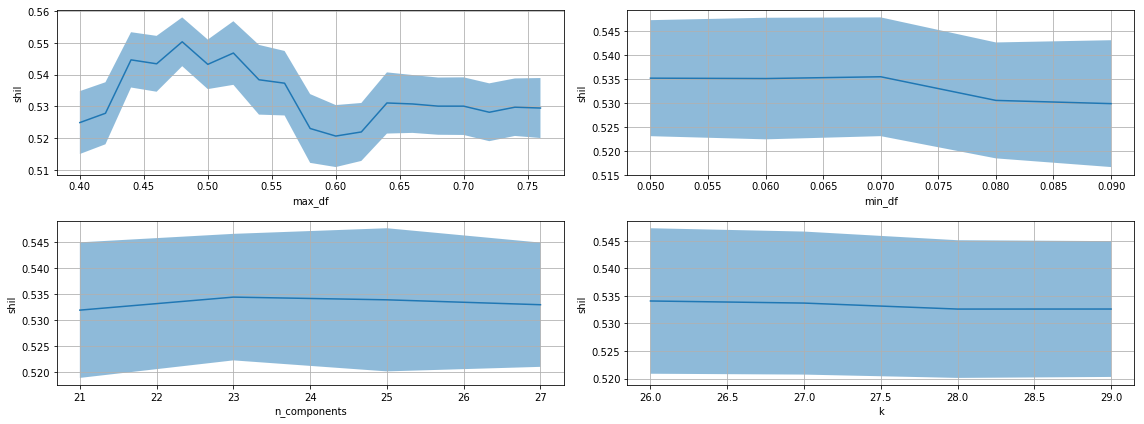

In [16]:
max_df_values = np.arange(0.40, 0.78, 0.02)
min_df_values = np.arange(0.05, 0.1, 0.01)
n_components_values = range(21, 28, 2)
k_values = range(26, 30, 1)

grid_search_kmeans(max_df_values, 
                       min_df_values, 
                       n_components_values, 
                       k_values,
                       'checkpoints/finer.csv')

In [17]:
finer_df = pd.read_csv('checkpoints/finer.csv', index_col=[0])
finer_df = finer_df.sort_values(by='shil', ascending=False).reset_index()
finer_df.head()

,index,shil,max_df,min_df,n_components,k
0,505,0.577503,0.52,0.06,25.0,26.0
1,506,0.574212,0.52,0.06,25.0,27.0
2,281,0.566184,0.46,0.07,25.0,26.0
3,201,0.565891,0.44,0.07,25.0,26.0
4,493,0.565487,0.52,0.05,27.0,26.0


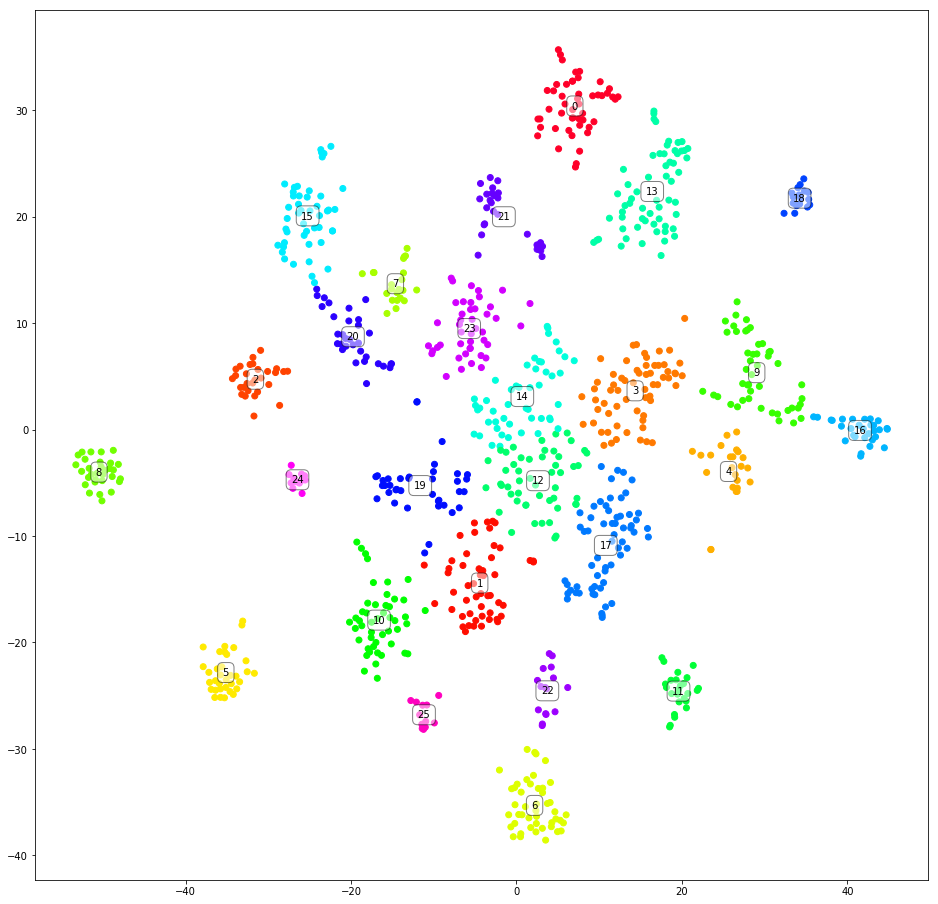

In [18]:
df = get_papers()
[
    _, 
    kmeans, 
    _, 
    _, 
    _, 
    _, 
    X_embedded
] = pipeline_kmeans((df, 
                finer_df.max_df.values[0], 
                finer_df.min_df.values[0], 
                int(finer_df.n_components.values[0]), 
                int(finer_df.k.values[0])))
plot_kmeans(X_embedded, kmeans)
# Saving the model to disk
if not os.path.exists('models/'):
    os.makedirs('models/')
pickle.dump(kmeans, open('models/kmeans.p', 'wb'))

We can see clear and separate clusters in the outer region of the papers space. The central part of that space is composed of a blob of papers which are just segmentated into a series of smaller blobs by k-means. Furthermore, there are several papers that are closer to papers in other clusters than to their corresponding centroid (e.g. cluster 15). That is the reason why the shilouette score is not that high. 

In the next section we apply the same process for DBSCAN. We expect DBSCAN to not assign some papers to clusters. More specifically, those papers that are in the border between clusters and may not clearly classified as belonging to one topic or another. We are also expecting DBSCAN to deal better with the central blob of papers. 

## DBSCAN model selection

In [19]:
def pipeline_dbscan(input_data):
            df = input_data[0]
            max_df = input_data[1]
            min_df = input_data[2]
            n_components = input_data[3]
            eps = input_data[4]
            min_samples = input_data[5]

            X_freq = build_bag_of_words(df, max_df = max_df, min_df = min_df)
            X_lsa = apply_lsa(X_freq, n_components = n_components)
            X_embedded = apply_dimensionality_reduction(X_lsa)
            dbscan, shil = dba_clustering(X_embedded, eps = eps, min_samples = min_samples)
            return [shil, dbscan, max_df, min_df, n_components, eps, min_samples, X_embedded]

In [20]:
def grid_search_dbscan(max_df_values, 
                       min_df_values, 
                       n_components_values, 
                       eps_values,
                       min_samples_values,
                       output_file,
                       n_jobs = 8):
    if not os.path.exists(output_file):
        # Pipeline initialisation
        df = get_papers()
        
        # Building the grid search space
        grid_search = [(df, max_df, min_df, n_components, eps, min_samples) 
                         for max_df in max_df_values
                         for min_df in min_df_values
                         for n_components in n_components_values
                         for eps in eps_values
                         for min_samples in min_samples_values]

        # Running the pipeline for all the elements in the grid search space
        results = Parallel(n_jobs=n_jobs)(delayed(pipeline_dbscan)(gs) for gs in tqdm(grid_search))

        # Processing the results data
        results_df = pd.DataFrame([], columns = ['shil', 'max_df', 'min_df', 'n_components', 'eps', 'min_samples'])
        for r in results:
            results_df.loc[len(results_df) + 1, :] = [r[0], r[2], r[3], r[4], r[5], r[6]]
        for c in results_df.columns:
            results_df[c] = results_df[c].astype(float)
        results_df.to_csv(output_file)
    else:
        results_df = pd.read_csv(output_file, index_col=[0])

    # Plotting the results
    fig, ax = plt.subplots(3,2)
    r = 0
    c = 0
    for col in results_df.columns[1:]:
        averages = results_df[[col, 'shil']].groupby(col).mean().sort_index()
        stds = results_df[[col, 'shil']].groupby(col).std().sort_index()

        ax[r, c].plot(averages.index.values, averages.values)
        ax[r, c].fill_between(averages.index.values, 
                        averages.values.flatten() - stds.values.flatten(),
                        averages.values.flatten() + stds.values.flatten(), 
                        alpha = 0.5)
        ax[r, c].grid(True)
        ax[r, c].set_xlabel(col)
        ax[r, c].set_ylabel('shil')

        c = c + 1
        if c > 1:
            c = 0
            r = r + 1
    fig.set_figwidth(16)
    fig.set_figheight(8)
    plt.tight_layout()

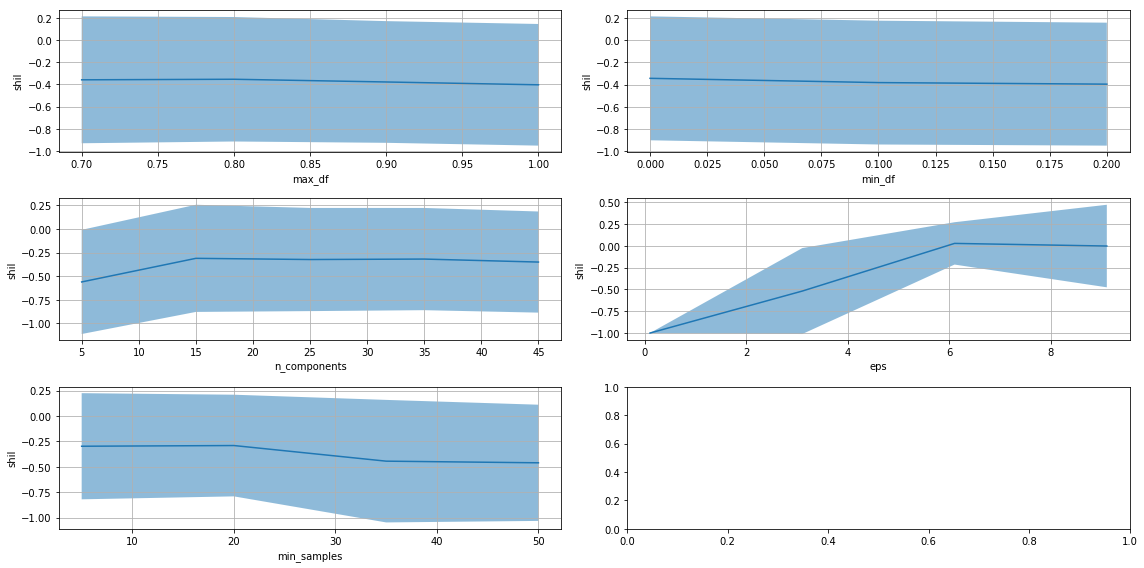

In [21]:
max_df_values = np.arange(0.7, 1, 0.1)
min_df_values = np.arange(0, 0.3, 0.1)
n_components_values = range(5, 50, 10)
eps_values = np.arange(0.1, 11.1, 3)
min_samples_values = range(5, 55, 15)

grid_search_dbscan(max_df_values, 
                   min_df_values, 
                   n_components_values, 
                   eps_values,
                   min_samples_values,
                   'checkpoints/dbscan_coarse.csv')

In [22]:
dbscan_df = pd.read_csv('checkpoints/dbscan_coarse.csv', index_col=[0])
dbscan_df = dbscan_df.sort_values(by='shil', ascending=False).reset_index()
dbscan_df.head()

,index,shil,max_df,min_df,n_components,eps,min_samples
0,409,0.404600,0.8,0.2,5.0,6.1,5.0
1,416,0.396511,0.8,0.2,5.0,9.1,50.0
2,415,0.390229,0.8,0.2,5.0,9.1,35.0
3,12,0.376501,0.7,0.0,5.0,6.1,50.0
4,5,0.376358,0.7,0.0,5.0,3.1,5.0


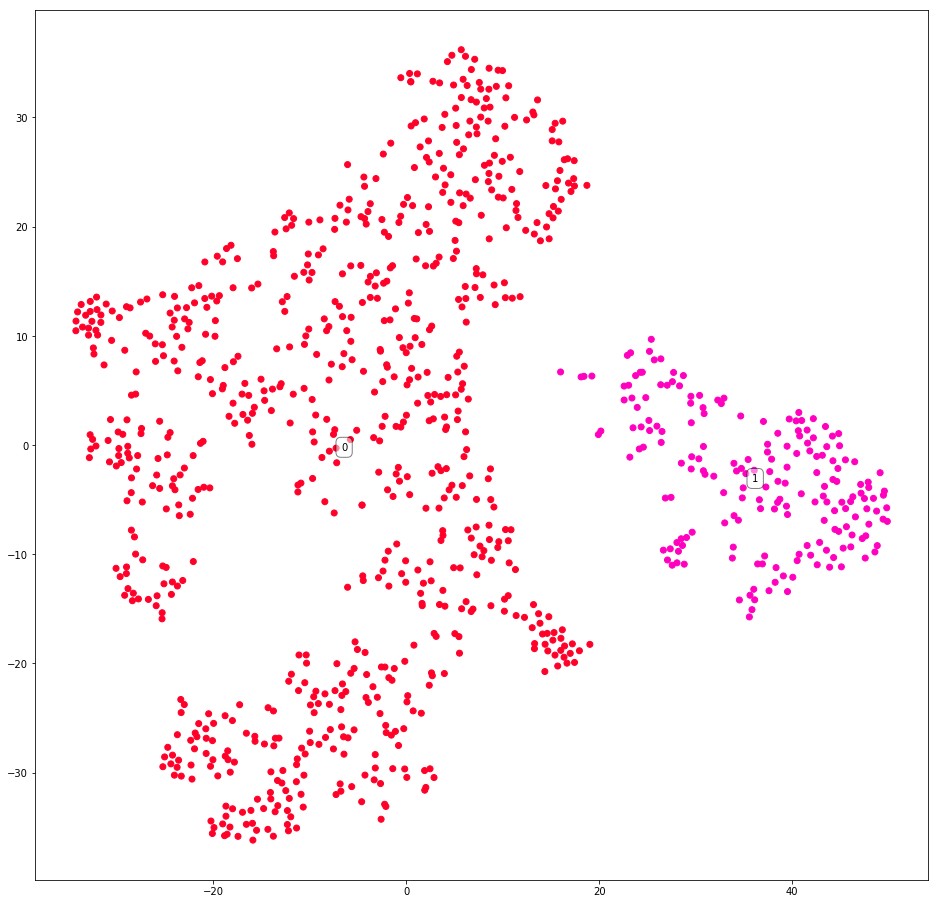

In [23]:
df = get_papers()
[
    _, 
    dbscan, 
    _, 
    _, 
    _, 
    _, 
    _,
    X_embedded
] = pipeline_dbscan((df, 
                dbscan_df.max_df.values[0], 
                dbscan_df.min_df.values[0], 
                int(dbscan_df.n_components.values[0]), 
                float(dbscan_df.eps.values[0]),
                int(dbscan_df.min_samples.values[0])))
plot_dbscan(X_embedded, dbscan)

Results for DBSCAN do not seem as meaningful as those of K-means for our particular problem. Using the shilouette metric results in only two clusters being detected. That is not particularly useful if we are trying to split the papers into categories. 